# Поиск изображений по запросу

**Цель исследования** — разработать демонстрационную версию проекта поиска изображений по запросу.

**Задача исследования** — обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

**PS:** Ячейки выполнялись по порядку, однако номера могут не показывать этого, т.к. периодичски ядро умирало, я сохраняла часть данных в файл, загружала и продолжала с того места, на котором остановилась. Ячейку выше у меня неполучилось редактировать/удалиь.

## 1. Изучение данных из файлов

In [ ]:
# установка необходимых библиотек
#!pip install sweetviz
#!pip install torchvision
#!pip install opencv-python
#!pip install ipywidgets
#!pip install nltk
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [100]:
# импорт необходимых библиотек
import numpy as np
import os
import pandas as pd
import random
import urllib
import time
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from math import ceil
import sweetviz as sv
from collections import Counter
from nltk.tokenize import word_tokenize
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

tqdm.pandas()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [101]:
# путь к директории
project_path = '/mnt/c/Users/Администратор/work/multilabeling/sborn_proj/datasets/'

# создание словаря с именем файла и ссылкой на него
urls = {
   'train_dataset': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/VPwd3TCR5klqQg',
                  f'{project_path}train_dataset.csv'),
    'test_queries': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/X1pH7DRGwzRPbg',
                  f'{project_path}/test_queries.csv'),
    'test_images': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/0LWvicMlRy0d4Q',
                  f'{project_path}/test_images.csv'),
    'CrowdAnnotations': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/FP23mw5J71Z6jQ',
                  f'{project_path}/CrowdAnnotations.tsv'),
    'ExpertAnnotations': ('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Vgcx78qkm1IUzA',
                  f'{project_path}/ExpertAnnotations.tsv')
} 

for url in urls:
# проверка наличия файла 
    if not os.path.exists(urls.get(url)[1]):
        print(urls.get(url)[1], 'файл не найден, будет загружен из сети')
# скачивание файла по ссылке url и размещение файла по пути file_name
        urllib.request.urlretrieve(*urls.get(url))

In [102]:
# чтение загруженных данных
# файлы формата csv
train_dataset = pd.read_csv(f'{project_path}/train_dataset.csv')
test_queries = pd.read_csv(f'{project_path}/test_queries.csv', sep='|', index_col=0)
test_images = pd.read_csv(f'{project_path}/test_images.csv')

# файлы формата tsv
crowd_annotations = pd.read_table(f'{project_path}/CrowdAnnotations.tsv', header=None)
expert_annotations = pd.read_table(f'{project_path}/ExpertAnnotations.tsv', header=None)

По очереди просмотрим первые строки датасетов.

In [103]:
# просмотр первых строк тренировочного датасета
train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [104]:
# просмотр первых строк датасета для тестирования
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [105]:
# датасет с изображения для тестирования
test_images.head()

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

Датасет *test_images* пока не кажется информативным, т.к. в папке *test_images* мы имеем изображения, необходимые для тестирование модели и их названия должны совпадать со значениями загруженной из таблицы.

In [106]:
# вывод первых строк датасета с данными по соответствию изображения и описания, полученного с помощью краудсорсинга
crowd_annotations.columns = ['filename', 'image_id', 'text = image, %',
                            'text = image, count', 'text != image, count']
crowd_annotations.head()

filename                     image_id  text = image, %  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

   text = image, count  text != image, count  
0                    3                     0  
1                    0                     3  
2                    0                     3  
3                    0                     3  
4                    0                     3

In [107]:
# вывод первых строк датасета с данными по соответствию изображения и описания, полученного в результате опроса экспертов
expert_annotations.columns = ['filename', 'image_id', 'expert1', 'expert2', 'expert3']
expert_annotations.head()

filename                     image_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   expert3  
0        1  
1        2  
2        2  
3        2  
4        2

**Вывод:**

Просмотрены исходные данные. Данные соответствуют описанию.

## 2. Исследовательский анализ данных

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Необходимо эти оценки агрегировать — превратить в одну. Воспользуемся голосованием большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Поскольку в качестве исходных данных мы получили датасеты с экспертными и краудсорсинговыми оценками, их также нужно агрегировать. 
Если у изображения-текста есть итоговая оценка экспертов и оценка крауда, то оценку экспертов примем с коэффициентом *0.6*, а крауда — с коэффциентом *0.4*.
Иначе в качестве таргета возьмём одну имеющуюся оценку крауда или экспертов.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1, поэтому оценки экспертов мы поделим на 4 (4 — максимальная оценка), а 
в качестве оценки крауда будем использовать долю исполнителей, подтвердивших, что текст соответствует картинке.

Выведем аналитические сводки для датасетов с экспертными и краудсорсинговыми оценками.

/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |                                                                …

/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/pytho


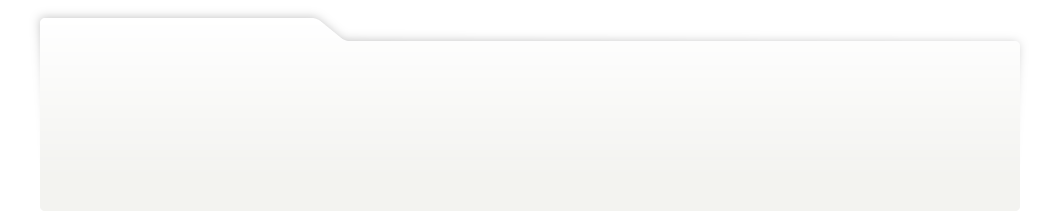
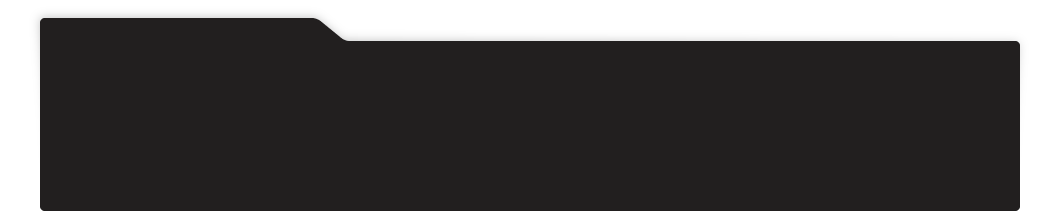
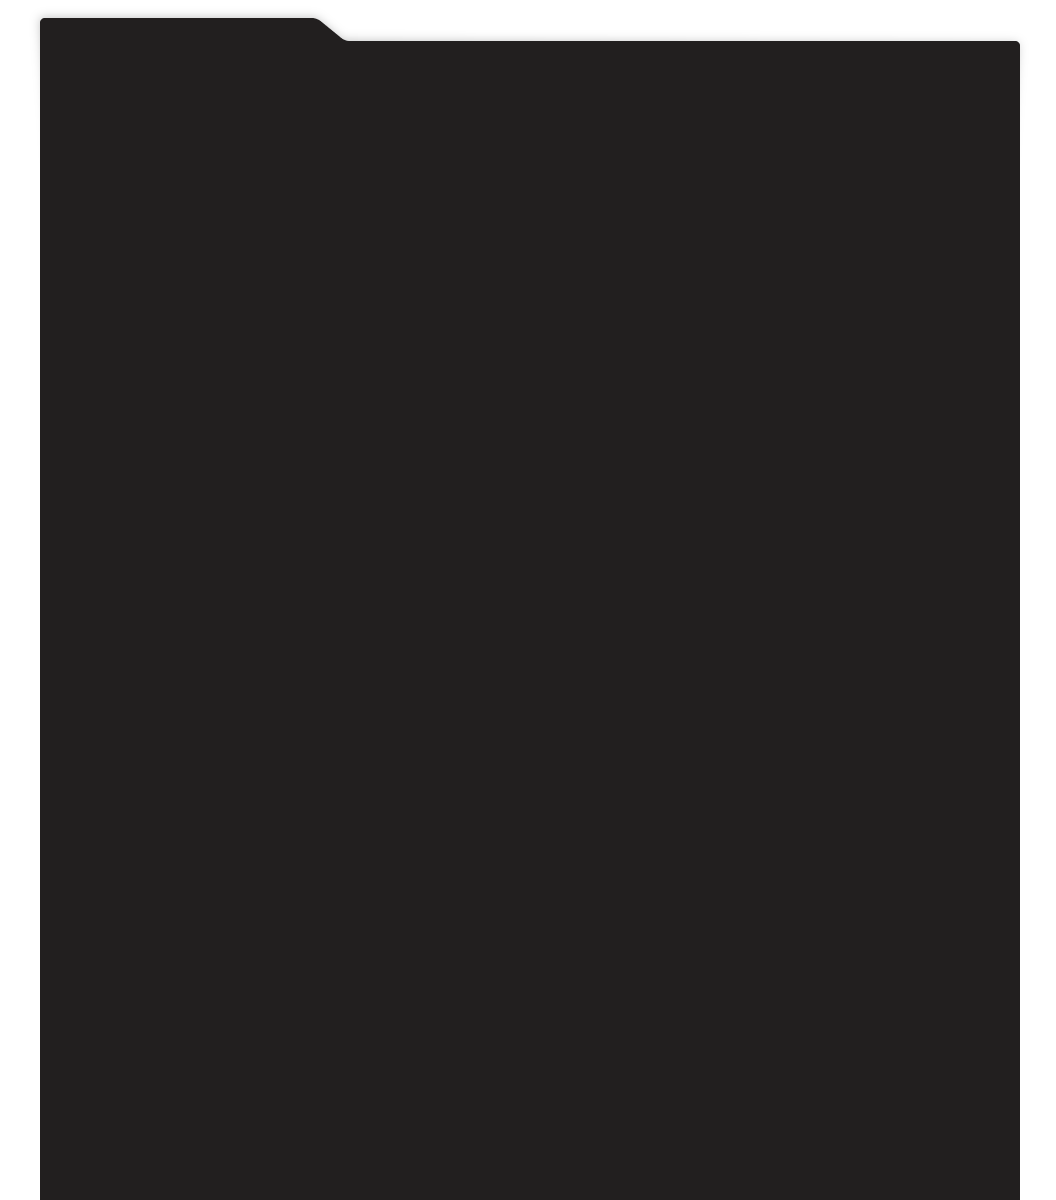
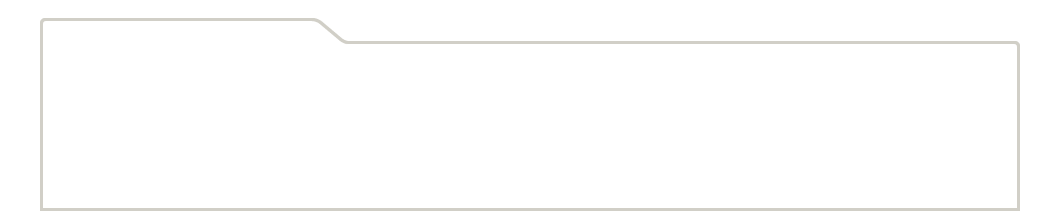
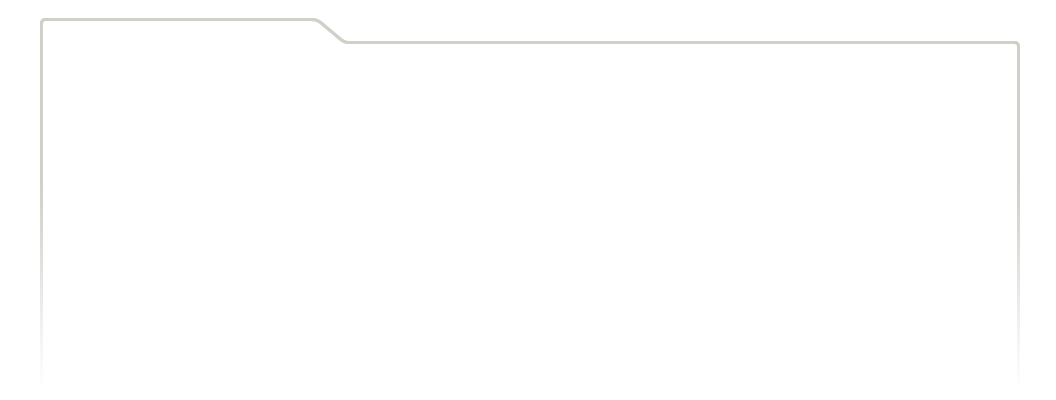
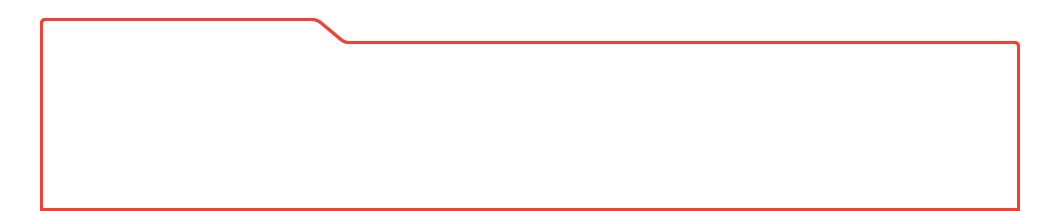
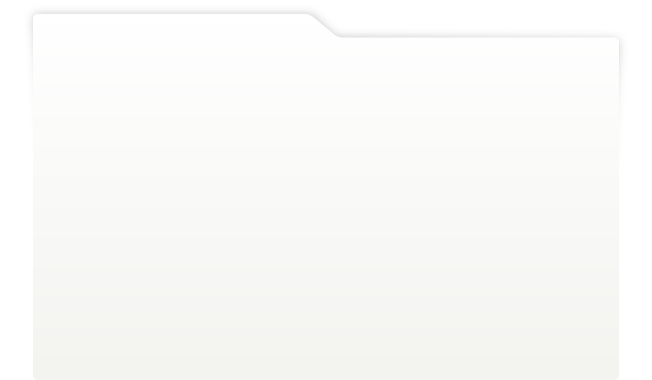
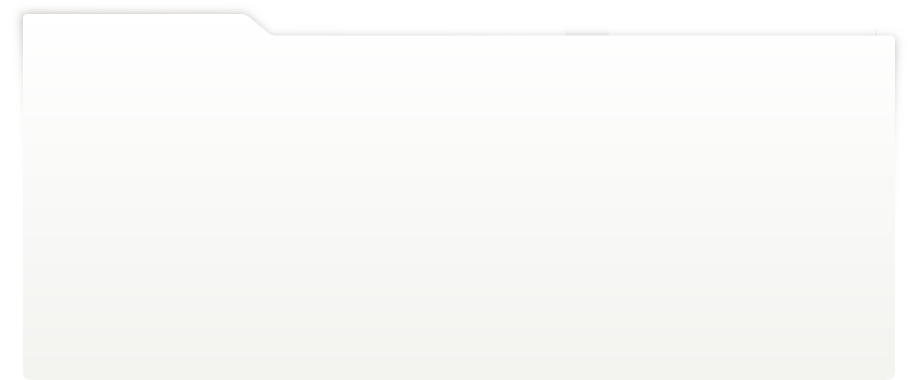
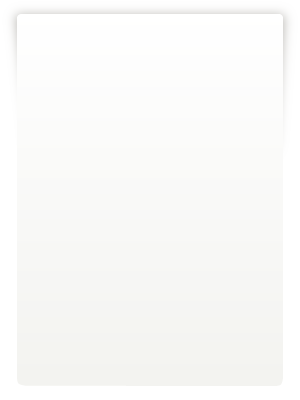
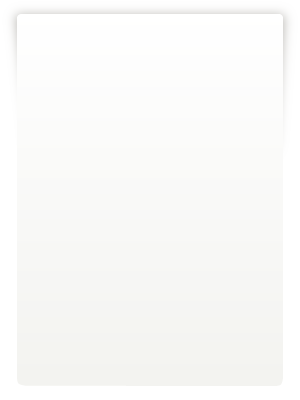
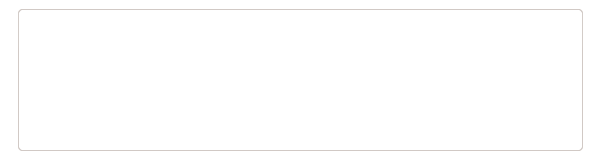
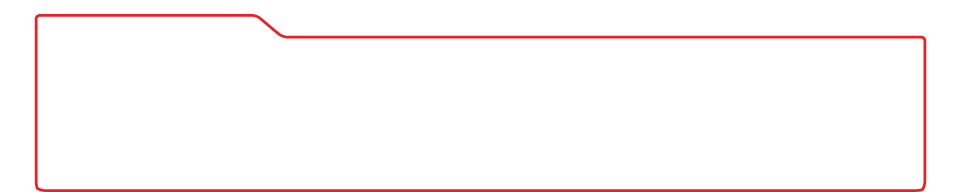
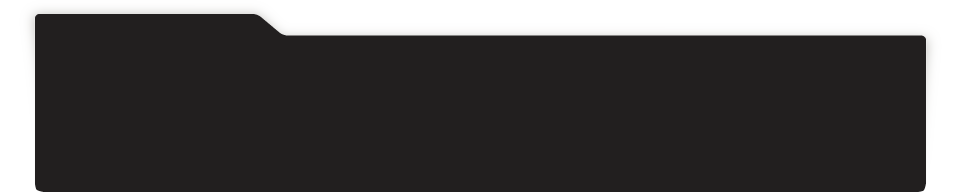
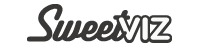
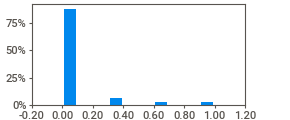
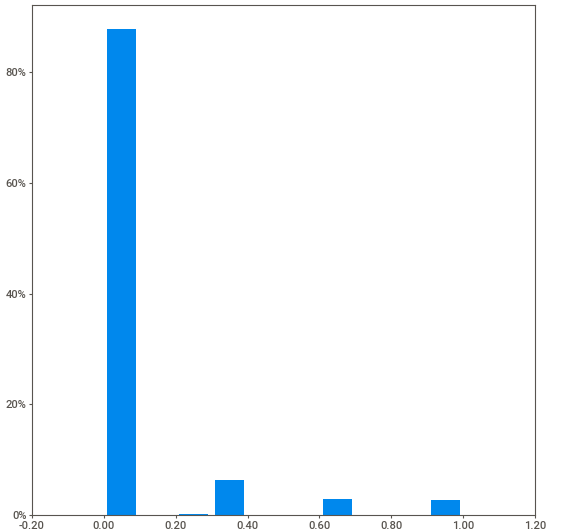
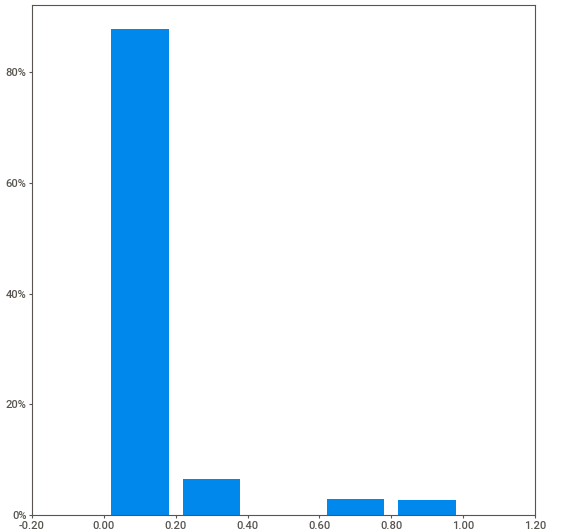
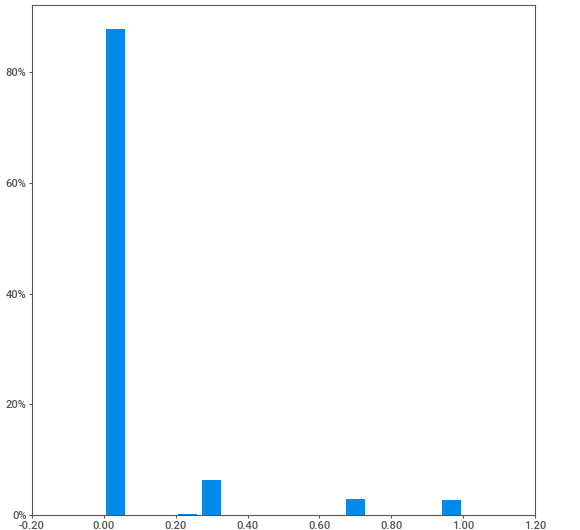
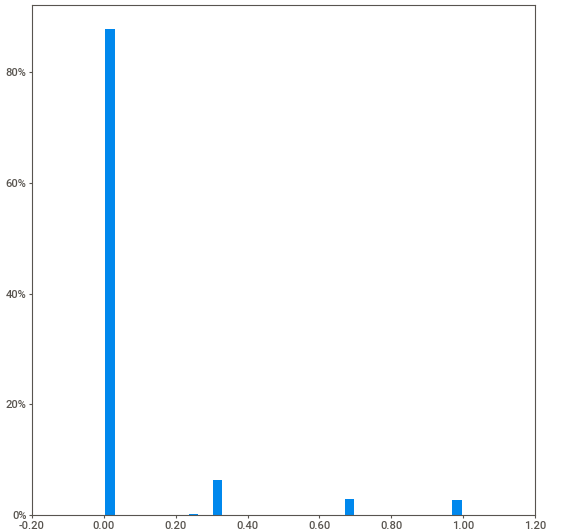
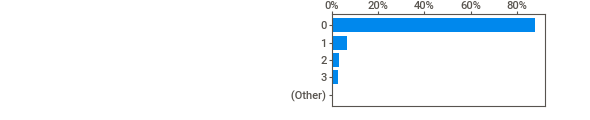
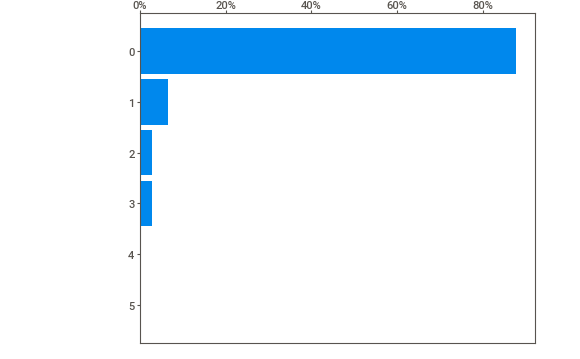
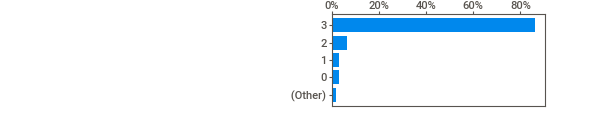
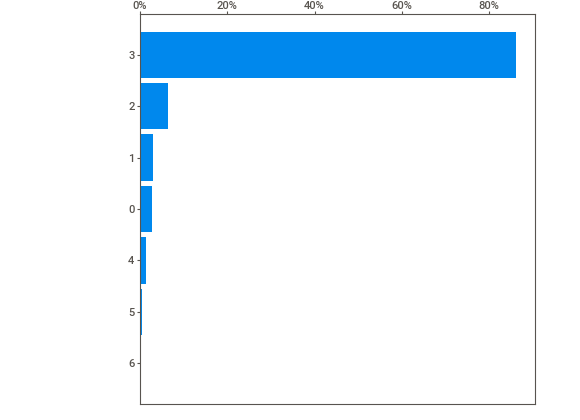
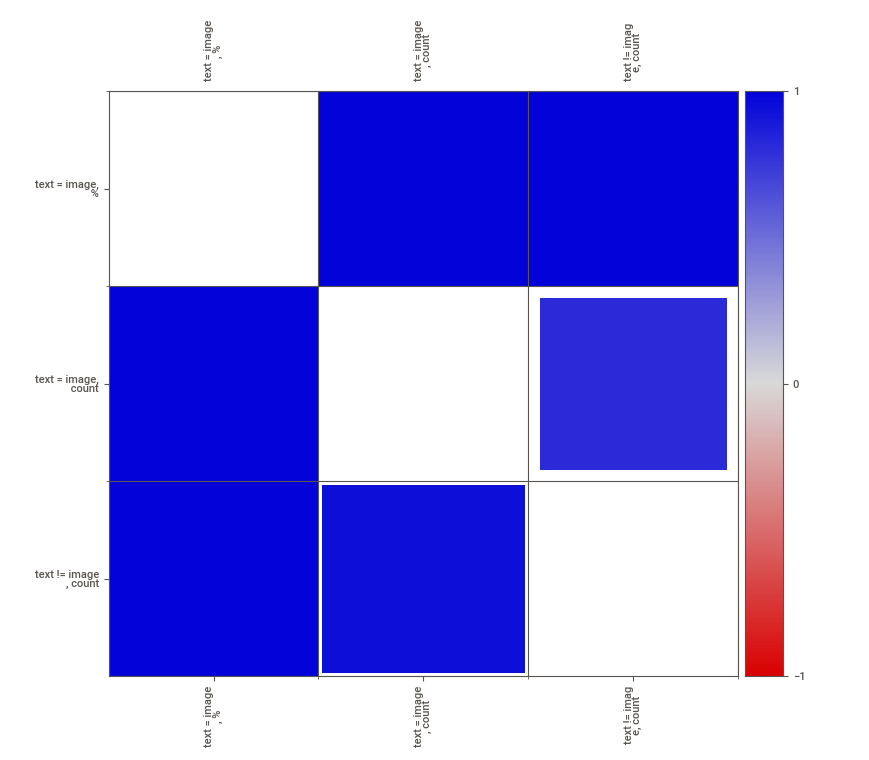
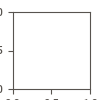

In [108]:
# вывод анализа датасета экспертных оценок
report = sv.analyze([crowd_annotations, 'crowd_annotations'])
report.show_notebook(w=1500, h=500)

/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |                                                                …

/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/sweetviz/series_analyzer_cat.py


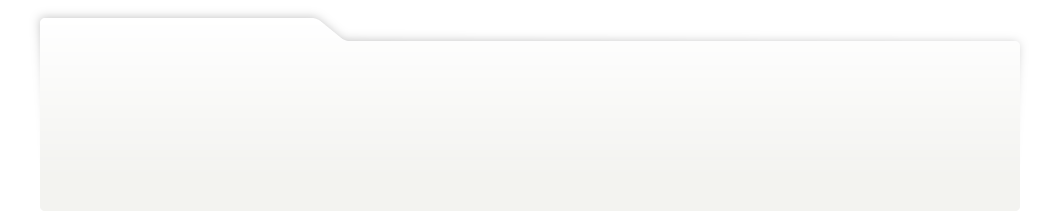
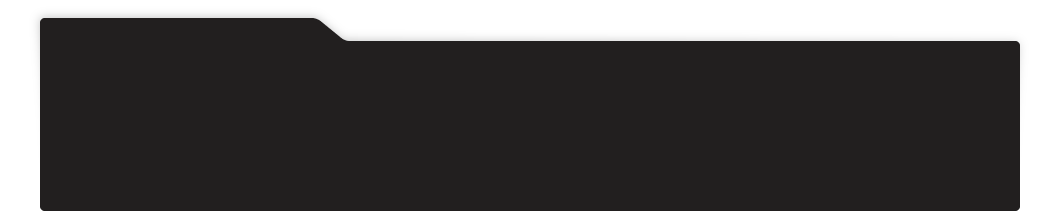
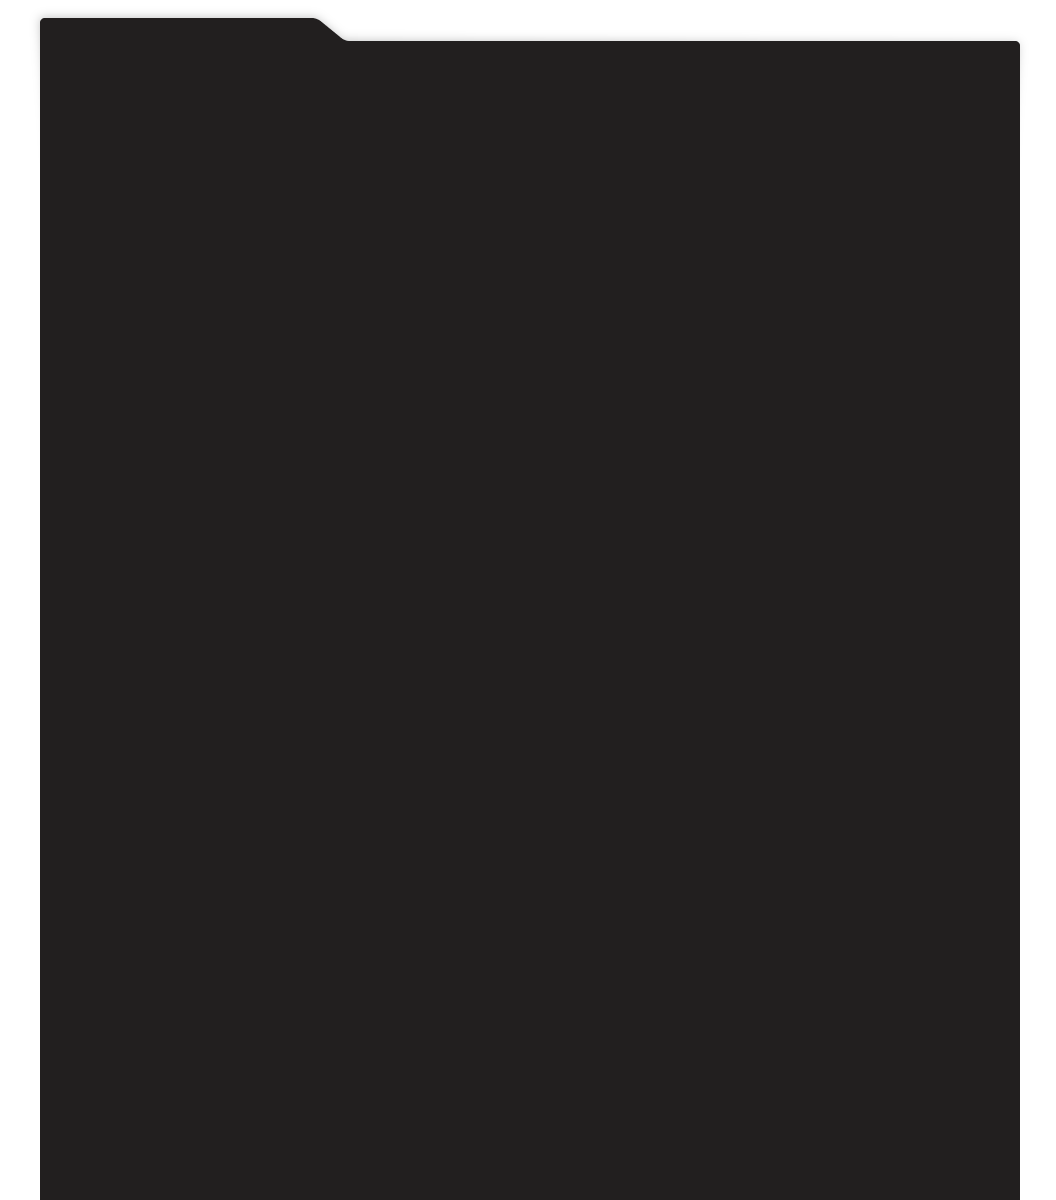
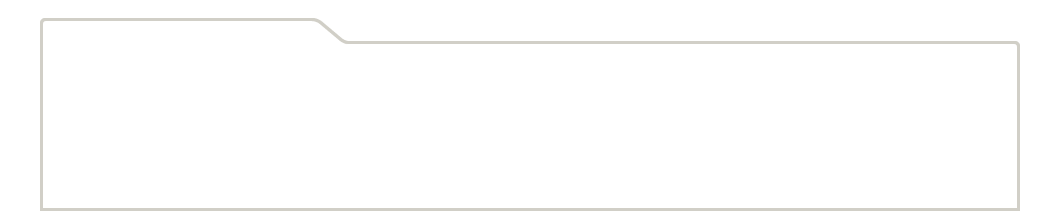
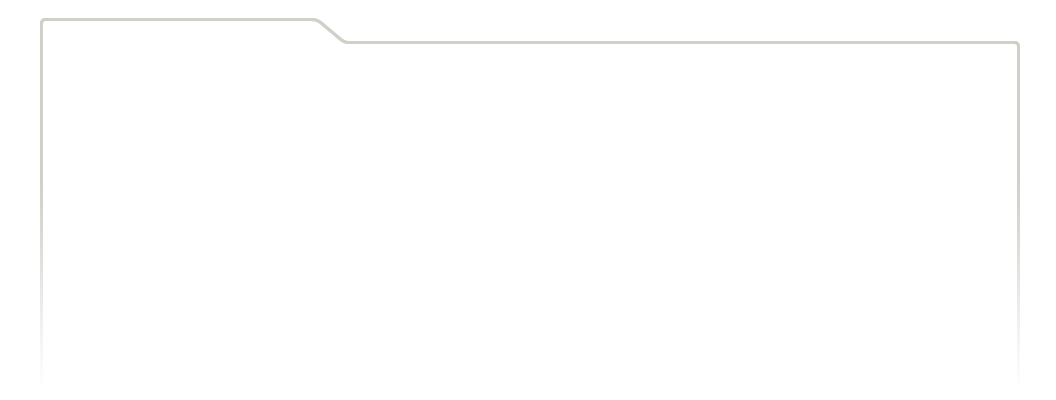
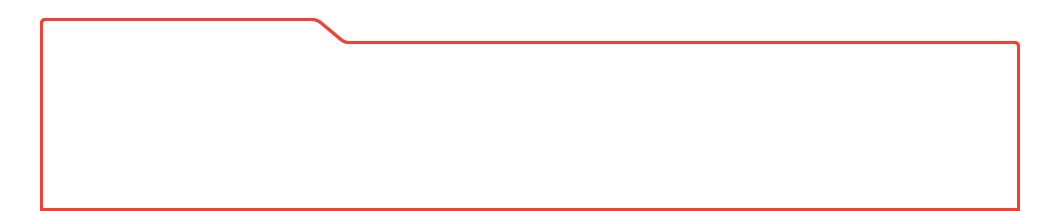
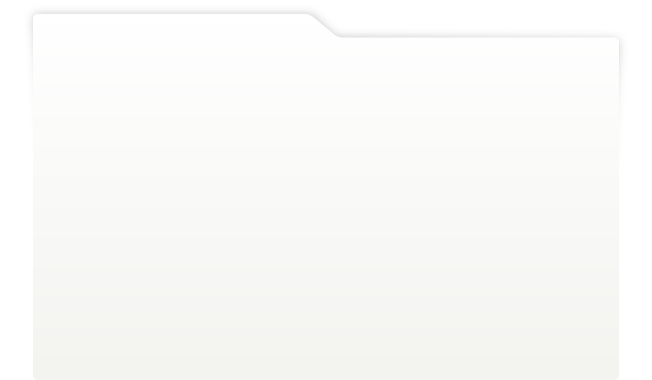
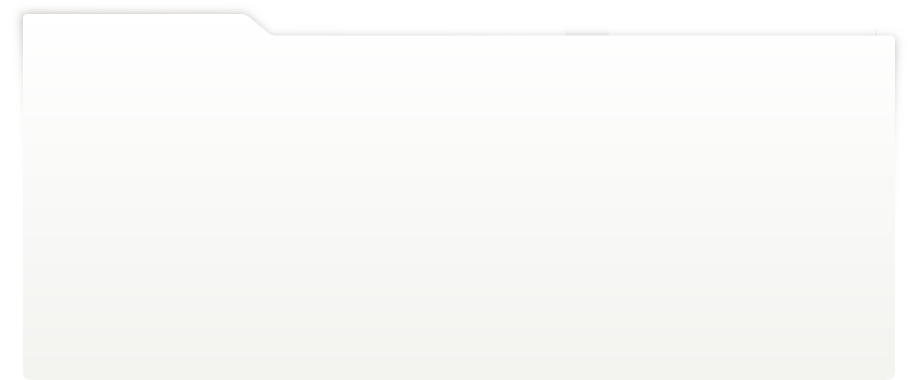
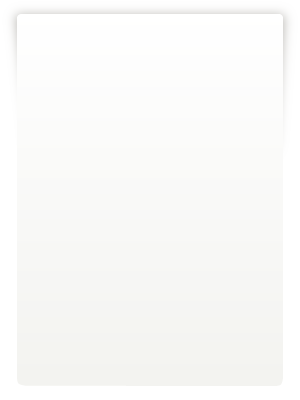
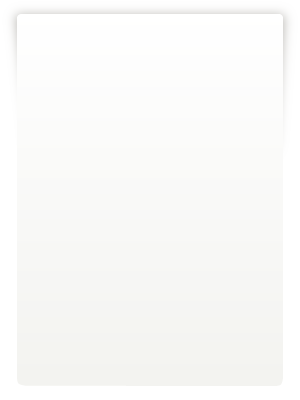
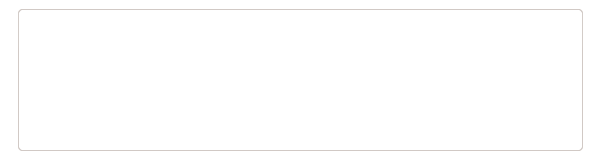
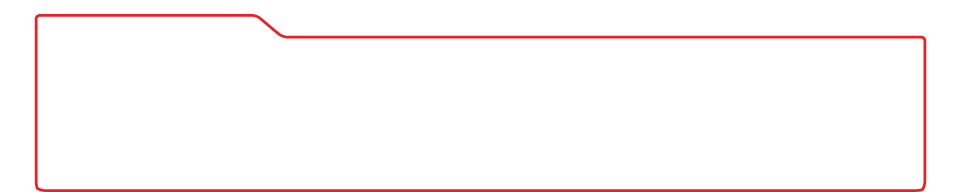
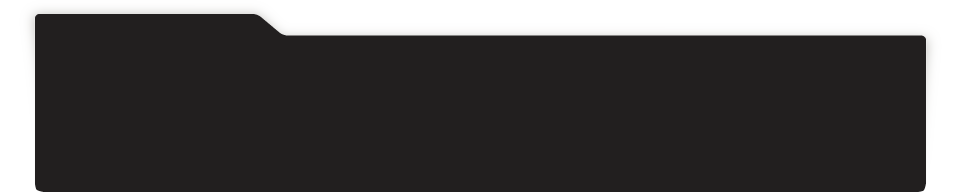
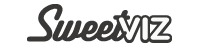
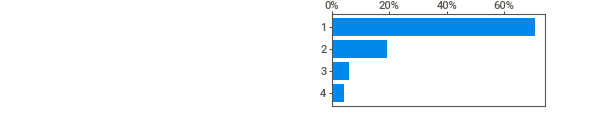
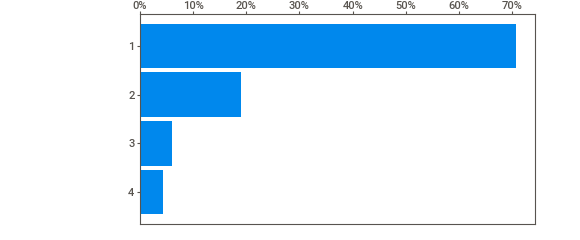
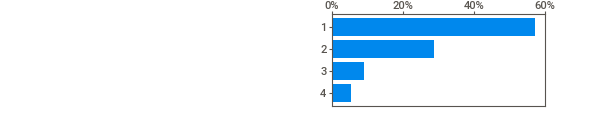
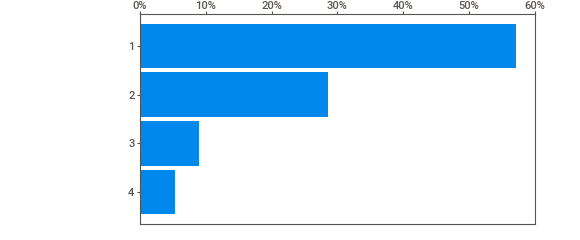
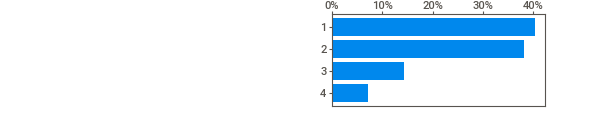
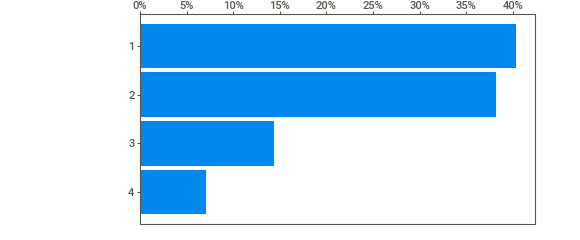
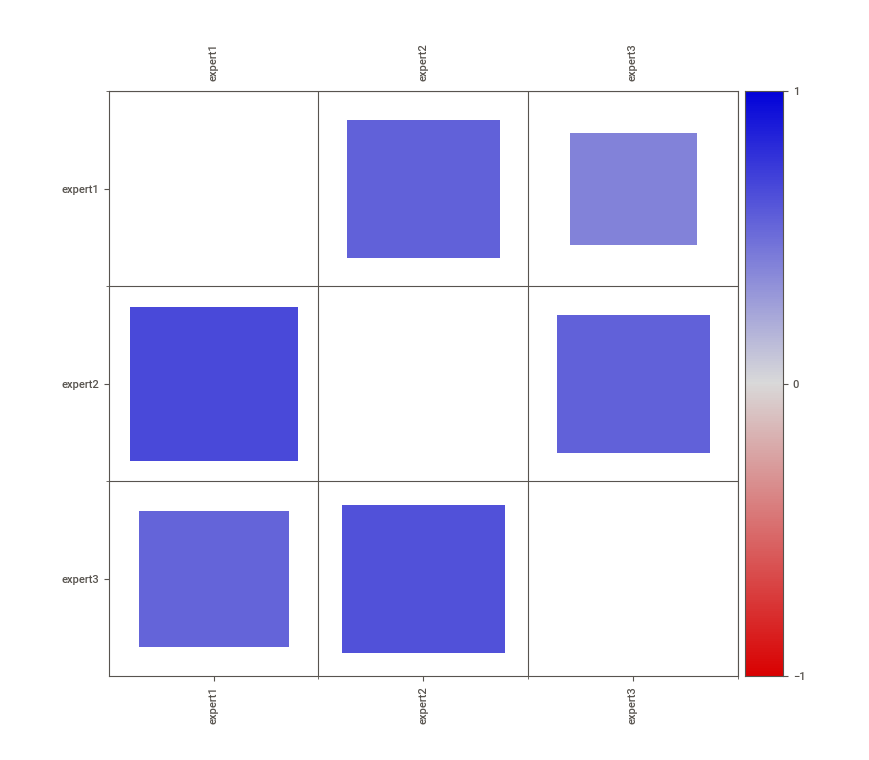
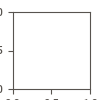

In [109]:
# вывод анализа датасета краудсорсинговых оценок
report = sv.analyze([expert_annotations, 'expert_annotations'])
report.show_notebook(w=1500, h=500)

Видим, что в исходных данных (для обеих таблиц) большая часть пар изображение-текст не соответствуют друг другу. Это повлияет на предсказательную способность модели. Также заметим, что экспертных оценок намного меньше краудсорсинговых, поэтому качество данных может быть не самым лучшим.

Отфильтруем таблицу *crowd_annotations* по количеству голосов: если за соответствие/несоответствие пары изображение-текст проголосовало меньше трёх человек, то такую пару удалим из датасета, т.к. по двум оценкам невсегда можно принять решение.

In [110]:
# подсчёт количества голосов
crowd_annotations['vote_counts'] = crowd_annotations.apply(lambda x:
                                                           x['text = image, count'] + x['text != image, count'],
                                                          axis=1)

In [111]:
# вывод первых строк
crowd_annotations.head()

filename                     image_id  text = image, %  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

   text = image, count  text != image, count  vote_counts  
0                    3                     0            3  
1                    0                     3            3  
2                    0                     3            3  
3                    0                     3            3  
4                    0                     3            3

In [112]:
# фильтруем датасет
crowd_annotations = crowd_annotations[crowd_annotations['vote_counts'] >= 3]

In [113]:
# просмотр уникальных значений
crowd_annotations['vote_counts'].value_counts()

3    46780
4      780
5      220
6       50
Name: vote_counts, dtype: int64

In [114]:
# размер датасета
crowd_annotations.shape

(47830, 6)

Размер датасета не изменился, значит, все сходные данные можно использовать для обучения.

In [115]:
# удаление лишних колонок
crowd_annotations.drop(columns=['text = image, count', 'text != image, count', 'vote_counts'], inplace=True)

Теперь для датасета *expert_annotations* создадим функцию для формирования итоговой оценки с помощью голосования большинства.

In [116]:
# вывод первых строк
expert_annotations.head()

filename                     image_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   expert3  
0        1  
1        2  
2        2  
3        2  
4        2

In [117]:
# функция формирования итоговой оценки с помощью голосования большинства
def final_grade(row, columns):
    values = []
    for column in columns:
        values.append(row[column])
    
    if len(set(values)) == len(values):
        return None
    else:
        return Counter(values).most_common(1)[0][0]

In [118]:
# применение функции
expert_annotations['experts'] = expert_annotations.apply(final_grade,
                                                         columns=['expert1', 'expert2', 'expert3'],
                                                         axis=1)

In [119]:
# вывод первых строк
expert_annotations.head()

filename                     image_id  expert1  expert2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2        1        1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2        1        1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2        1        1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2        1        2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2        1        1   

   expert3  experts  
0        1      1.0  
1        2      1.0  
2        2      1.0  
3        2      2.0  
4        2      1.0

In [120]:
# просмотр наличия пропуска
expert_annotations.isna().mean()

filename    0.000000
image_id    0.000000
expert1     0.000000
expert2     0.000000
expert3     0.000000
experts     0.021642
dtype: float64

Удалим пропущенные значения, т.к. в таком случае все эксперты поставили разные оценки и мы не можем сформировать итоговую оценку голосованием большинства.

In [121]:
# удаление пропусков
expert_annotations.dropna(inplace=True)

In [122]:
# просмотр наличия пропуска
expert_annotations.isna().mean()

filename    0.0
image_id    0.0
expert1     0.0
expert2     0.0
expert3     0.0
experts     0.0
dtype: float64

Приведём оценки экспертов в шкалу от 0 до 1.

In [123]:
# нормализация оценок экспертов
expert_annotations['experts'] = expert_annotations['experts'] / 4

In [124]:
# удалить лишние колонки
expert_annotations.drop(columns=['expert1', 'expert2', 'expert3'], inplace=True)

In [125]:
# просмотр первых строк
expert_annotations.head()

filename                     image_id  experts
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.25
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     0.25
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     0.25
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     0.50
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     0.25

In [126]:
# просмотр максимального/минимального значения
print('Максимальная оценка экспертов', expert_annotations.experts.max())
print('Минимальная оценка экспертов', expert_annotations.experts.min())

Максимальная оценка экспертов 1.0
Минимальная оценка экспертов 0.25


In [127]:
# размер датасета
expert_annotations.shape

(5696, 3)

Размер датасета с экспертными оценками немного уменьшился.

Объединим датасеты с оценками краудов и экспертов.

In [128]:
# объединение датасетов
annotations = crowd_annotations.merge(expert_annotations, how='outer', on=['filename', 'image_id'])
print('Размер датасета с оценками', annotations.shape)

Размер датасета с оценками (51268, 4)


In [129]:
# просмотр пропусков
annotations.isna().mean()

filename           0.000000
image_id           0.000000
text = image, %    0.067059
experts            0.888898
dtype: float64

Пропуски образовались на местах, где нет какой-либо из оценок. Если у пары изображение-текст присутствует обе оценки, то учтём их с коеффициентами, иначе примем имеющуюся оценку.

In [130]:
# преобразование оценок c помощью коэффициентов
annotations['text = image, %'].fillna('пропуск', inplace=True)
annotations['final_rate'] = annotations.apply(
    lambda x: x['text = image, %'] * 0.4 + x['experts'] * 0.6 if x['text = image, %'] != 'пропуск' else x['experts'], axis=1)

In [131]:
# формирование оценки для пар с единственной оценкой крауда
annotations['final_rate'].fillna(annotations['text = image, %'], inplace=True)

In [132]:
# вывод пропусков
annotations.isna().mean()

filename           0.000000
image_id           0.000000
text = image, %    0.000000
experts            0.888898
final_rate         0.000000
dtype: float64

Пропущенных значений в столбце `final_rate` не имеется, следовательно, все итоговые оценки сформированы. Удалим ненужные колонки из таблицы.

In [133]:
# удаление колонок
annotations.drop(columns=['text = image, %', 'experts'], inplace=True)

**Вывод:**

Проведён исследовательский анализ оценок краудов и экспертов. Сформирован датасет с агрегированными оценками краудов и экспертов.

## 3. Проверка данных

В некоторых странах действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.
Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Отберём слова, которые могут указывать на ребёнка и внесём их в список исключений.

In [64]:
# слова-исключения
exclude_words = ['child', 'adolescent', 'teenage child', 'adolescent child', 'ypung person', 'kid',
                 'kids', 'baby', 'juvenile', 'adolescence', 'young man', 'young girl', 'newborn',
                 'infant', 'toddler', 'teen', 'girl', 'boy', 'children']

Создадим функцию обработки текста на наличие конкекста, связанного с детьми.

In [65]:
# функция обработки текста с помощью списка стов-исключений
def cleared_text(text, exclude_words):
    tokenized_text = word_tokenize(text)
    for word in exclude_words:
        if word in tokenized_text:
            return None
    return text 

In [66]:
# применение функции
train_dataset['final_text'] = train_dataset['query_text'].apply(lambda x: cleared_text(x, exclude_words))

In [67]:
# просмотр первых строк
train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text final_text  
0  A young child is wearing blue goggles and sitt...       None  
1  A young child is wearing blue goggles and sitt...       None  
2  A young child is wearing blue goggles and sitt...       None  
3  A young child is wearing blue goggles and sitt...       None  
4  A young child is wearing blue goggles and sitt...       None

In [68]:
# переименование колонок
train_dataset.columns = ['image', 'image_id', 'query_text', 'final_text']

Удалим из датасета пары изображение-текст, которые не подходят под условие.

In [69]:
# удаление пропусков в final_text
train_dataset.dropna(inplace=True)

In [70]:
# оставляем необходимые колонки
train_dataset = train_dataset[['image_id', 'final_text']]

Объединим датасеты *annotations* и *train_dataset*. 

In [71]:
# оставляем необходимые колонки
image_text_data = annotations.merge(train_dataset, how='inner', on='image_id')

In [72]:
# вывод первых строк
image_text_data.head()

filename                     image_id  final_rate  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2         1.0   
1  2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2         0.0   
2  2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2         0.0   
3  2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2         0.0   
4  2892995070_39f3c9a56e.jpg  1056338697_4f7d7ce270.jpg#2         0.0   

                                          final_text  
0  A woman is signaling is to traffic , as seen f...  
1  A woman is signaling is to traffic , as seen f...  
2  A woman is signaling is to traffic , as seen f...  
3  A woman is signaling is to traffic , as seen f...  
4  A woman is signaling is to traffic , as seen f...

In [73]:
# удаление пропусков и дубликатов
image_text_data.dropna(subset=['final_text'])
image_text_data.drop_duplicates(inplace=True)

In [74]:
# размер итогового датасета
image_text_data.shape

(38637, 4)

**Вывод:**

Проверены данные на наличие изображений/текстов о детях. Сформирован итоговый датасет для предобработки перед обучением моделей.

## 4. Векторизация изображений

Переходим к векторизации изображений. Будем использовать архитектуру *ResNet-18* для формирования эмбедингов изображений.

Загрузим тренировочную модель и заморозим веса, чтобы модель не обучалась. Два последних словя не будут использоваться. Также проведём нормализацию данных.

In [75]:
# загрузка архитекутры и заморозка весов
resnet = models.resnet18(pretrained=True) 
for param in resnet.parameters():
    param.requires_grad_(False) 

# выбор слоёв архитектуры и инициализация режима предсказания  
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)
resnet.eval()

# нормализация данных
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
]) 

/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/c/Users/Администратор/work/multilabeling/multilabel_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [77]:
# загрузка тренировочных изображений
train_images_path = Path('/mnt/c/Users/Администратор/work/multilabeling/sborn_proj/datasets/train_images')
train_images_list = [str(dataset) for dataset in train_images_path.rglob('*.jpg')]

# формирование эмбедингов изображений
train_tensors = []
for image in tqdm(train_images_list):
    img = Image.open(image).convert('RGB') 
    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
    train_tensors.append(output_tensor)
    
# формирование списка изображений
images_list = []
for image in train_images_list:
    images_list.append(image.split('/')[-1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.28it/s]


Эмбединги изображений сформированы. Создаздим датасет для объединения эмбедингов с изображениями и сохраним эмбединги в отдельный файл.

In [49]:
# формирование датасета с эмбедингами
train_image_tensor_data = pd.DataFrame({'filename': images_list,
                                        'tensor': train_tensors})
data_image_tensor = annotations.merge(train_image_tensor_data, how='left', on='filename')

# сохранение тензоров изображений
torch.save(data_image_tensor.tensor.values, 'image_tensors.pt')

In [ ]:
# вывод первых строк
data_image_tensor.head()

filename                     image_id  final_rate  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2         1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2         0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2         0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2         0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2         0.0   

                                              tensor  
0  [tensor(1.4565), tensor(1.4630), tensor(0.0038...  
1  [tensor(1.4565), tensor(1.4630), tensor(0.0038...  
2  [tensor(1.4565), tensor(1.4630), tensor(0.0038...  
3  [tensor(1.4565), tensor(1.4630), tensor(0.0038...  
4  [tensor(1.4565), tensor(1.4630), tensor(0.0038...

**Вывод:**

Изображения преобразованы в вектора и сохранения в файлы.

## 5. Векторизация текстов

Следующий этап — векторизация текстов. В качестве векторизатора будем использовать трансформер *bert-base-uncased*.

In [ ]:
# инициализация модели и токенизатора
model_path = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)
# перевод модели на GPU
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [144]:
# удаление колонок из датасета
image_text_data.drop(columns=['filename', 'final_rate'], inplace=True)
# формирование датасета для векторизации текста
final_data = data_image_tensor.merge(image_text_data, how='left', on='image_id')

In [145]:
# удаление дубликатов и пропусков
final_data.drop_duplicates(inplace=True)
final_data.dropna(inplace=True)

Данные подготовлены для векторизации. Для начала необходимо токенизировать описания, далее привести токензированные описания к одной длине, т.е. короткие описания будем дополнять нулями до необходимой длины.
После этого с помощью *bert-base-uncased* получим эмбединги.

In [ ]:
# токенизация комментариев
max_len = 512
tokenized = final_data['final_text'].progress_apply(lambda x:
                                      tokenizer.encode(x, truncation=True, max_length=max_len, add_special_tokens=True)
                                     )

# приведение описаний к одной длине
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38637/38637 [00:02<00:00, 18921.29it/s]


In [ ]:
%%time
# создание эмбедингов описаний
batch_size = 100
embeddings = []
for i in tqdm(range(round((padded.shape[0] / batch_size) + 1))):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [13:26<00:00,  2.08s/it]

CPU times: user 13min 25s, sys: 133 ms, total: 13min 25s
Wall time: 13min 26s


In [ ]:
# конкатенация эмбедингов
text_embeddings = np.concatenate(embeddings)
# вывод одного эмбединга
text_embeddings[0]

array([ 4.38436531e-02,  1.07649677e-01, -1.80561945e-01, -3.12109664e-02,
        7.88594931e-02, -8.12274069e-02,  4.42492723e-01,  5.41437685e-01,
       -4.56781507e-01, -4.05548751e-01, -2.34942585e-01, -1.63387358e-01,
        1.84192494e-01,  3.58917564e-01,  6.94214702e-01,  1.64983664e-02,
       -1.58312917e-01,  4.56853569e-01,  4.08920646e-01, -2.50730604e-01,
       -2.83745736e-01, -1.52789116e-01, -1.73571315e-02, -3.50785613e-01,
        2.12011293e-01, -2.99801975e-02,  7.75582567e-02,  8.98563676e-03,
       -2.52129585e-01, -5.86118773e-02,  1.22864768e-01,  5.65938652e-01,
       -3.07746023e-01, -4.52233315e-01,  2.61535794e-01, -3.09034616e-01,
        2.66834885e-01, -2.26032864e-02,  1.31332621e-01,  2.92180985e-01,
       -2.17654899e-01, -3.43131512e-01, -2.79631047e-03, -8.87839273e-02,
       -6.79782778e-02, -7.45732665e-01, -2.43237519e+00, -2.28732914e-01,
       -3.14313680e-01, -9.11033452e-02, -1.05976932e-01,  9.25104693e-02,
        1.48504943e-01,  

Создадим список эмбедингов описаний и сохраним в файл.

In [ ]:
# создание списка эмбедингов
torch_text_embeddings = []
for emb in text_embeddings:
    emb = torch.FloatTensor(emb)
    torch_text_embeddings.append(emb)
    
# сохранение в файл
torch.save(torch_text_embeddings, 'text_tensors.pt')

**Вывод**:

Описания изображений переведены в векторное пространство.

## 6. Объединение векторов

Для обучения модели необходимо объединить векторы изображений и векторы текстов.

In [ ]:
# создание списка конкатенированных эмбедингов
concat_tensors = []
for i,j in zip(data_image_tensor.tensor.values, torch_text_embeddings):
    tensor = torch.cat([i[None, :], j[None, :]], dim=1)[0]
    concat_tensors.append(tensor)             

In [ ]:
# размер одного вектора
len(concat_tensors[0])

25856

**Вывод**:

Векторы изображений и векторы описаний объединены. Длина итоговоого вектора каждой пары изображение-текст составляет 25856.

## 7. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Исключим попадание изображения и в обучающую, и в тестовую выборки с помощью *GroupShuffleSplit*.

На наших данных опробуем 2 модели обучения:
* LinearRegression()
* fully connected neural network (полносвзяная нейронная сеть)

In [9]:
# получение индексов тренировочной и тестовой выборок
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=final_data.drop(columns=['final_rate', 'filename']), y=final_data['final_rate'], groups=final_data['filename']))

In [10]:
# выделение тренировочных и тестовых тензоров
tensors_train = [concat_tensors[i] for i in train_indices]
tensors_test = [concat_tensors[i] for i in test_indices]

# выделение тренировочных и тестовых тензоров
target = final_data.final_rate.values
test_target = [target[i] for i in test_indices]
train_target = [target[i] for i in train_indices]

In [11]:
# переопределние тензоров для линейной регрессии
linear_tensors_train = np.array([tensor.detach().numpy() for tensor in tensors_train])
linear_tensors_test = np.array([tensor.detach().numpy() for tensor in tensors_test])

# переопределение таргетов для линейной регрессии
train_target = np.array(train_target)
test_target = np.array(test_target)

In [85]:
# для закрепления состояния
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # some cudnn methods can be random even after fixing the seed unless you tell it to be deterministic
    torch.backends.cudnn.deterministic = True

seed_everything(1234)

Для линейной регрессии создадим отдельный класс, т.к. модель линейной регрессии из *sklearn* очень долго обучается.

In [13]:
# создание класса линейной регрессии
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [14]:
# задание параметров и инициализация модели
input_dim = 25856 
output_dim = 1 
learning_rate =  0.00001 
epochs = 100

model = linearRegression(input_dim, output_dim)
##### For GPU #######
if torch.cuda.is_available():
    model.to(device)
    
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Теперь обучим модель линейной регрессии.

In [15]:
# входные данные
inputs = torch.FloatTensor(linear_tensors_train).to(device)
labels = torch.FloatTensor(train_target).to(device)

In [16]:
# обучение линейной регрессии
for epoch in range(epochs):
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()
     # get output from the model, given the inputs
    outputs = model(inputs)

    criterion = torch.nn.MSELoss() # get loss for the predicted output
    loss = criterion(outputs.flatten(), labels.flatten())

    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    
    print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 0.8722066283226013
epoch 1, loss 0.7199492454528809
epoch 2, loss 0.6756250858306885
epoch 3, loss 0.6960785388946533
epoch 4, loss 0.7170854806900024
epoch 5, loss 0.71095210313797
epoch 6, loss 0.6839836239814758
epoch 7, loss 0.6516667604446411
epoch 8, loss 0.6264929175376892
epoch 9, loss 0.6138200163841248
epoch 10, loss 0.6113696098327637
epoch 11, loss 0.6119948029518127
epoch 12, loss 0.6087125539779663
epoch 13, loss 0.5985836386680603
epoch 14, loss 0.5831568241119385
epoch 15, loss 0.5664434432983398
epoch 16, loss 0.5523757338523865
epoch 17, loss 0.542941689491272
epoch 18, loss 0.5375329852104187
epoch 19, loss 0.533657968044281
epoch 20, loss 0.528576135635376
epoch 21, loss 0.520827054977417
epoch 22, loss 0.5107711553573608
epoch 23, loss 0.500042200088501
epoch 24, loss 0.490447461605072
epoch 25, loss 0.482975035905838
epoch 26, loss 0.4773794114589691
epoch 27, loss 0.47249481081962585
epoch 28, loss 0.4670303463935852
epoch 29, loss 0.460326403379440

Лосс уменьшается, следовательно, модель обучается. Посчитаем метрику качества на тестовой выборке. В качесте метрики будет использовать *MSE*.

In [17]:
# расчёт метрики на тестовой выборке
model.eval()
inputs_test = torch.FloatTensor(linear_tensors_test).to(device)
labels_test = torch.FloatTensor(test_target).to(device)

predictions = model(inputs_test)
predictions = predictions.cpu().detach().numpy()
labels_test = labels_test.cpu().detach().numpy()
print('MSE =', mean_squared_error(labels_test, predictions))

MSE = 0.31831288


Теперь опробуем модель полносвязной нейронной сети. Для этого сначала зададим архитектуру нейронной сети в виде класса.

In [86]:
# создание архитектуры нейронной сети
class Net(nn.Module):
    def __init__(self, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_hidden_neurons_4, n_hidden_neurons_5):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(25856, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=0.3)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=0.3)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.dp3 = nn.Dropout(p=0.3)
        self.act3 = nn.ReLU()
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.dp4 = nn.Dropout(p=0.3)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5)
        self.dp5 = nn.Dropout(p=0.3)
        self.act5 = nn.ReLU()
        self.fc6 = nn.Linear(n_hidden_neurons_5, 1)
        self.dp6 = nn.Dropout(p=0.1)
        self.act6 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.dp3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.dp4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.dp5(x)
        x = self.act5(x)
        x = self.fc6(x)
        x = self.dp6(x)
        x = self.act6(x)
        
        return x

Далее инициализируем нейронную сеть и задаём функцию обучения сети.

In [87]:
# инициализация сети
net = Net(500, 70, 50, 15, 8).to(device)

In [88]:
# функция обучения нейронной сети
def train(b_size, n_epochs, x_torch_train, y_torch_train, x_torch_test, y_torch_test, net = net):

    # обучение и тестирование
    batch_size = b_size # размер батча
    num_epochs = n_epochs # количество эпох обчуения
    loss = torch.nn.MSELoss() 
    
    num_batches = ceil(len(x_torch_train)/batch_size) # расчёт количества батчей
    
    optimizer = torch.optim.Adam(net.parameters(), lr=0.000001) # оптимизатор

    for epoch in range(num_epochs):
        # случайная перестановка объектов
        order = np.random.permutation(len(x_torch_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()
        
            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = x_torch_train[batch_indexes]
            y_batch = y_torch_train[batch_indexes]
    
            preds = net.forward(X_batch).flatten() 
                
            loss_value = loss(preds, y_batch)

            loss_value.backward()
     
            optimizer.step()


        net.eval()
        test_preds = net.forward(x_torch_test)
        metric = mean_squared_error(test_preds.cpu().detach().numpy(), y_torch_test.cpu().detach().numpy())
        if epoch == num_epochs - 1:
            print('Final MSE -', metric)
        else:
            print(f'epoch {epoch}, loss {loss_value}, MSE -', metric)

In [89]:
# обучение сети
inputs_test = torch.FloatTensor(linear_tensors_test).to(device)
labels_test = torch.FloatTensor(test_target).to(device)
train(120, 50, inputs, labels, inputs_test, labels_test)

epoch 0, loss 0.0600186251103878, MSE - 0.04922855
epoch 1, loss 0.015615650452673435, MSE - 0.048672926
epoch 2, loss 0.10037389397621155, MSE - 0.04845646
epoch 3, loss 0.05972006171941757, MSE - 0.048247915
epoch 4, loss 0.022751063108444214, MSE - 0.048128676
epoch 5, loss 0.09660302847623825, MSE - 0.04793502
epoch 6, loss 0.06494242697954178, MSE - 0.04779933
epoch 7, loss 0.02976924739778042, MSE - 0.047731627
epoch 8, loss 0.05744091048836708, MSE - 0.04769293
epoch 9, loss 0.06971510499715805, MSE - 0.04773028
epoch 10, loss 0.014872279949486256, MSE - 0.04765055
epoch 11, loss 0.04320714995265007, MSE - 0.04764983
epoch 12, loss 0.034035298973321915, MSE - 0.047619846
epoch 13, loss 0.03803849220275879, MSE - 0.04766879
epoch 14, loss 0.023327097296714783, MSE - 0.047616597
epoch 15, loss 0.047000396996736526, MSE - 0.047629688
epoch 16, loss 0.009762725792825222, MSE - 0.04765821
epoch 17, loss 0.08730228245258331, MSE - 0.04761524
epoch 18, loss 0.01147209107875824, MSE - 0

In [93]:
# тестирование
net.eval()
predictions = net.forward(inputs_test)
predictions = predictions.cpu().detach().numpy()
labels_test = labels_test.cpu().detach().numpy()
print('MSE =', mean_squared_error(labels_test, predictions))

MSE = 0.04782713


**Вывод:**

Полносвязная ейронная сеть показала результат значительно лучше линейной регрессии, поэтому в качестве финальной модели выбираем полносвязную нейронную сеть.

## 8. Тестирование модели

Протестируем нейронную на изображениях из папки `test_images`, для этого выберем 10 случайных запросов из файла `test_queries.csv` и для каждого запроса выведем релевантное изображение. 
Визуально ценим результат.

In [95]:
# просмотр первых строк тестовых запросов
test_queries.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [96]:
# отбор 10ти случайных запросов
text_sample = test_queries.sample(10, random_state=100)

In [97]:
# получение эмбедингов текстов
query_text_list = text_sample.query_text.values
query_text_emb_list = []

max_len = 512
for text in query_text_list:
    tokenized = tokenizer.encode(text, truncation=True, max_length=max_len, add_special_tokens=True)
    padded = np.array(tokenized + [0]*(max_len - len(tokenized)))
    attention_mask = np.where(padded != 0, 1, 0)
    x = torch.LongTensor(padded).unsqueeze(0).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask).unsqueeze(0).to(device)
    
    with torch.no_grad():
        batch_embeddings = model(x, attention_mask=attention_mask_batch)
    query_text_emb_list.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())

In [98]:
# формирование тензоров изображений
test_images_path = Path(f'{project_path}/test_images')
test_images_list = [str(dataset) for dataset in test_images_path.rglob('*.jpg')]

test_tensors = []
for image in tqdm(test_images_list):
    img = Image.open(image).convert('RGB') 
    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
    test_tensors.append(output_tensor)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.46it/s]


Men playing with a red ring out in the field .


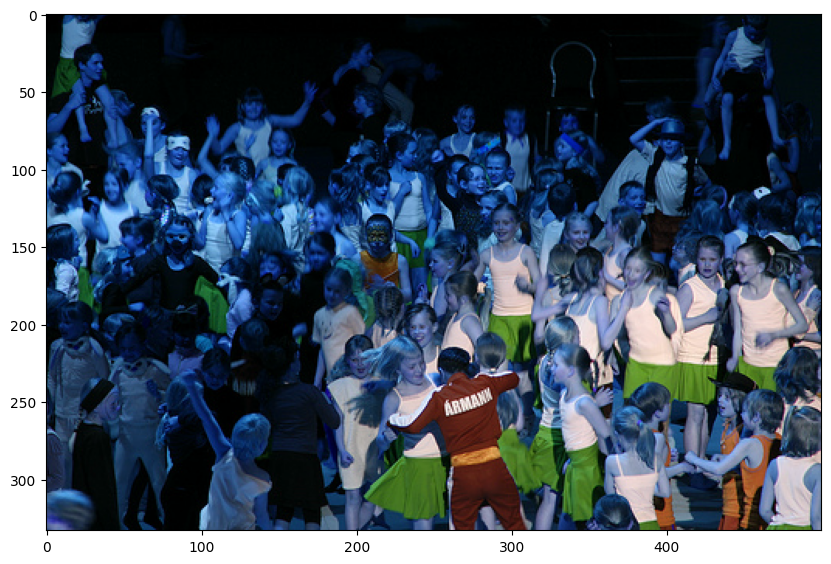

two young girls wearing pink outfits playing on yellow monkey bars .
This image is unavailable in your country in compliance with local laws

two girls walking in the street
This image is unavailable in your country in compliance with local laws

Women wearing red and black are clapping .


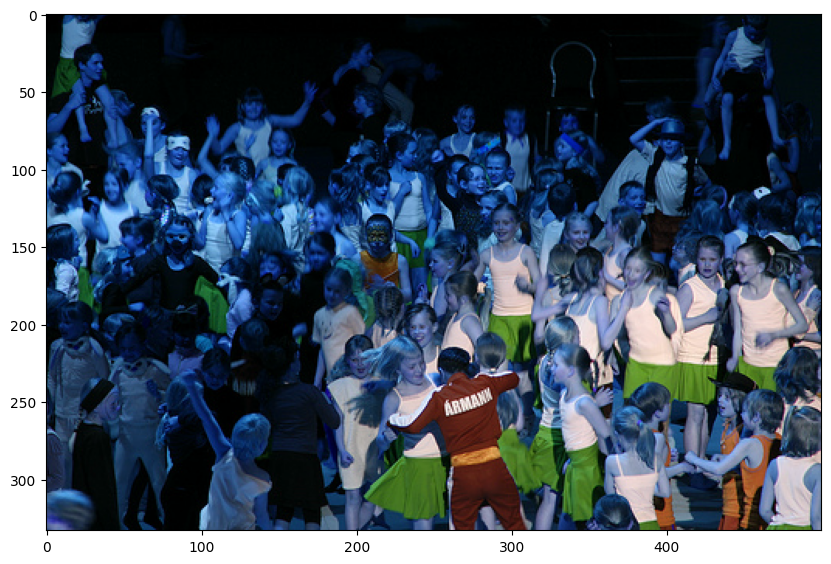

Two men kickbox in a ring , one man punching the other .


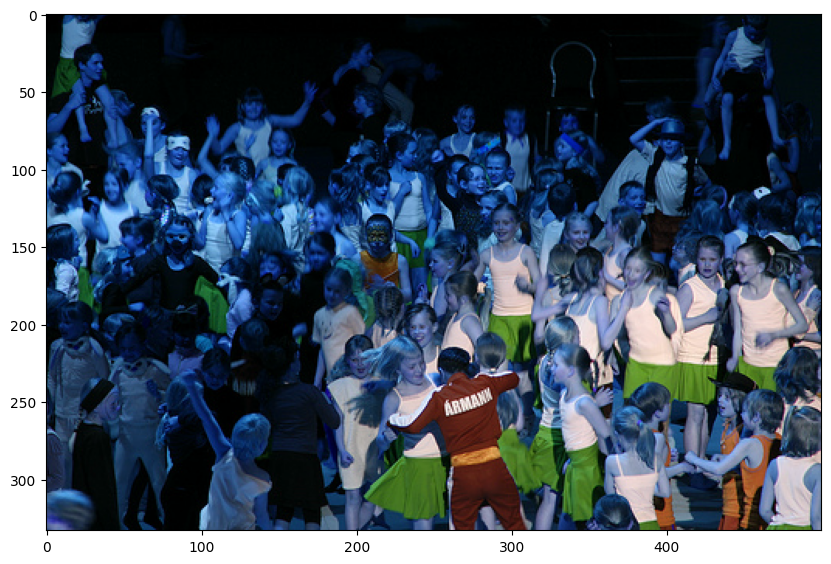

Children in costumes standing in line .
This image is unavailable in your country in compliance with local laws

little dog is jumping up to catch a red ball in its mouth .


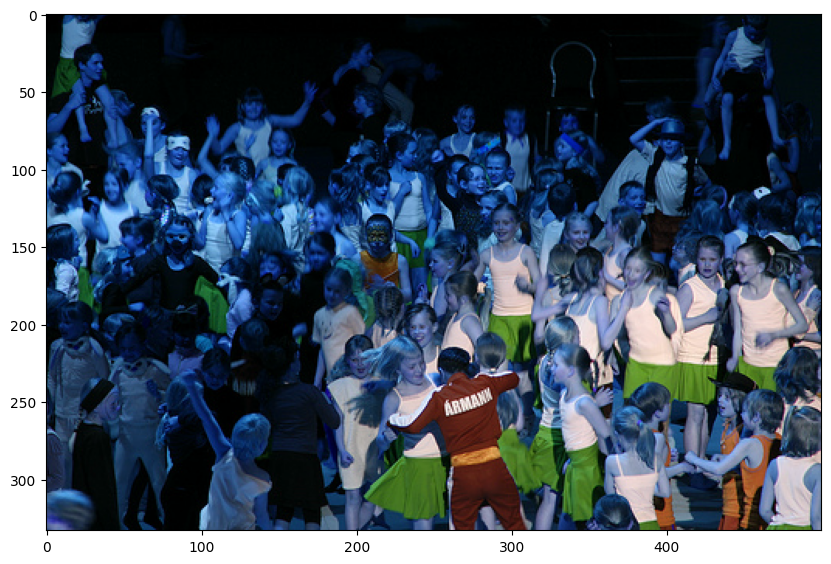

Woman with glasses working at a sewing machine .


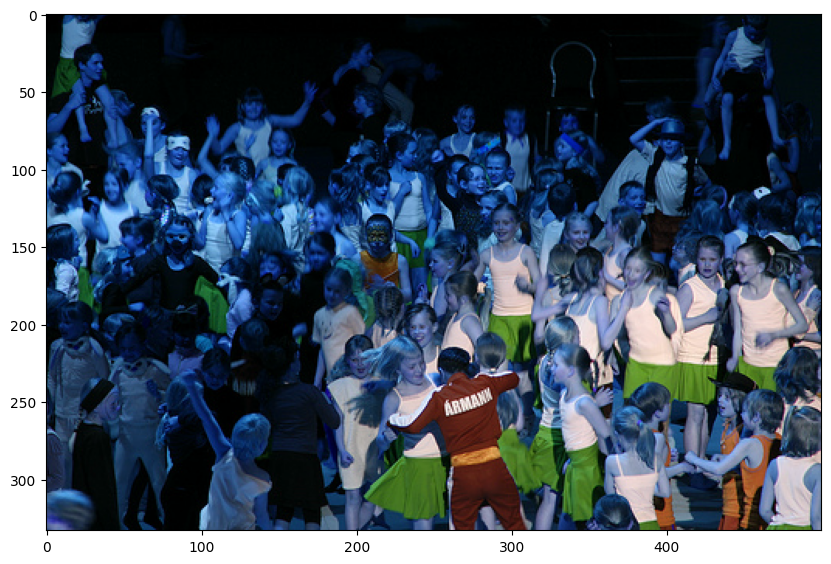

A boy and a girl at the beach , throwing sand .
This image is unavailable in your country in compliance with local laws

a tan dog jumping through the field with some barren trees in the background


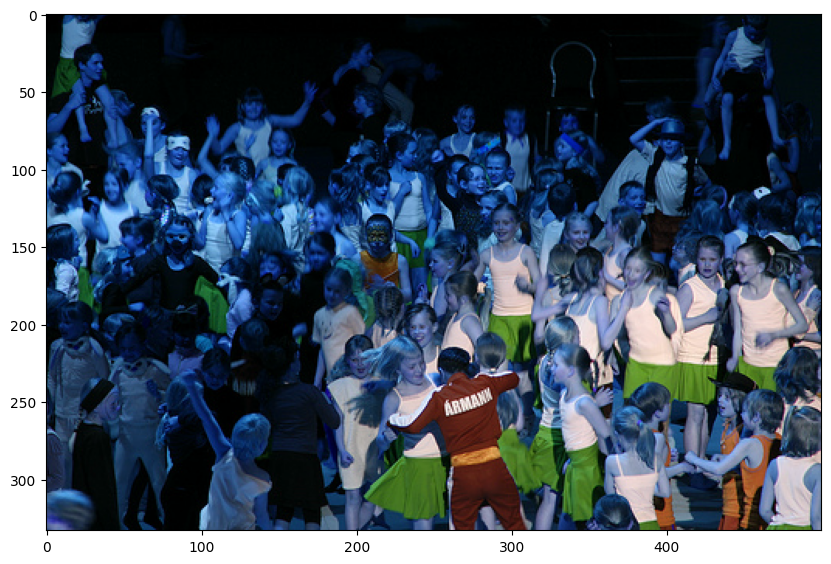

In [99]:
# тестирование модели нейросети
net.eval()
for text_emb in range(len(query_text_emb_list)):
    pred_value = []
    for i in range(len(test_tensors)):
        concat_tensor = torch.cat([test_tensors[i].unsqueeze(0), torch.LongTensor(query_text_emb_list[text_emb])], dim=1)[0].to(device)
        preds = net.forward(concat_tensor)[0]
        preds = float(preds.cpu().detach().numpy())
        pred_value.append(preds)
    images = [pred_value.index(value) for value in pred_value if value == max(pred_value)]
    print(query_text_list[text_emb])
    
    # если в описании присутствуют дети, то такое изображение мы не показываем, а показываем сообщение (см. ниже)
    do_not_show = None
    for word in exclude_words:
        if word in query_text_list[text_emb].lower():
            do_not_show = 'This image is unavailable in your country in compliance with local laws'
            print(do_not_show)
            print()
            break
    
    if not do_not_show:
        for image in images:
            img = cv2.imread(f'/mnt/c/Users/Администратор/work/multilabeling/sborn_proj/datasets/test_images/{images_list_test[image]}')  # открываем изображение
            plt.figure(figsize = (10, 10))
            plt.imshow(img)
            plt.show()

**Вывод:**

Некоторые описания частично соответствуют фотографиям, однако в целом нейросеть показывает не очень хороший результат. Это может быть связано с исходными данными,
т.к. превалирующую часть данных составляют пары изображение-текст, которые не соответствуют друг другу.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска